In [49]:
import os
import sys

import numpy as np
import math
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo as mc
import montecarlo_tools as mct
import chirality_tools as chir
from numba import jit
from numba_progress import ProgressBar


ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

# Ok lets see wtf

Here i just want to generate a typical ice rule state

In [50]:
N = 10
a = params["lattice_constant"]

# initialize neutral charge colloid
sp = ice.spins()
sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")


particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"]
            )


trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"]
            )


col = ice.colloidal_ice(sp, particle, trap,
                        height_spread = params["height_spread"], 
                        susceptibility_spread = params["susceptibility_spread"],
                        periodic = params["isperiodic"])

    
col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a
col.randomize()

In [51]:
col1 = col.copy(deep=True)

flips = [i + j for i in range(0,10,2) for j in range(0,100,20)] + [i + j for i in range(1,10,2) for j in range(10,100,20)]
flips = flips + [i + j for i in range(101,110,2) for j in range(0,100,20)] + [i + j for i in range(100,110,2) for j in range(10,100,20)]
flips = []

col1 = mct.flip_colloids(col1, indices= flips)
trj = mc.numpy2trj(*mc.trj2numpy(col1.to_ctrj()))

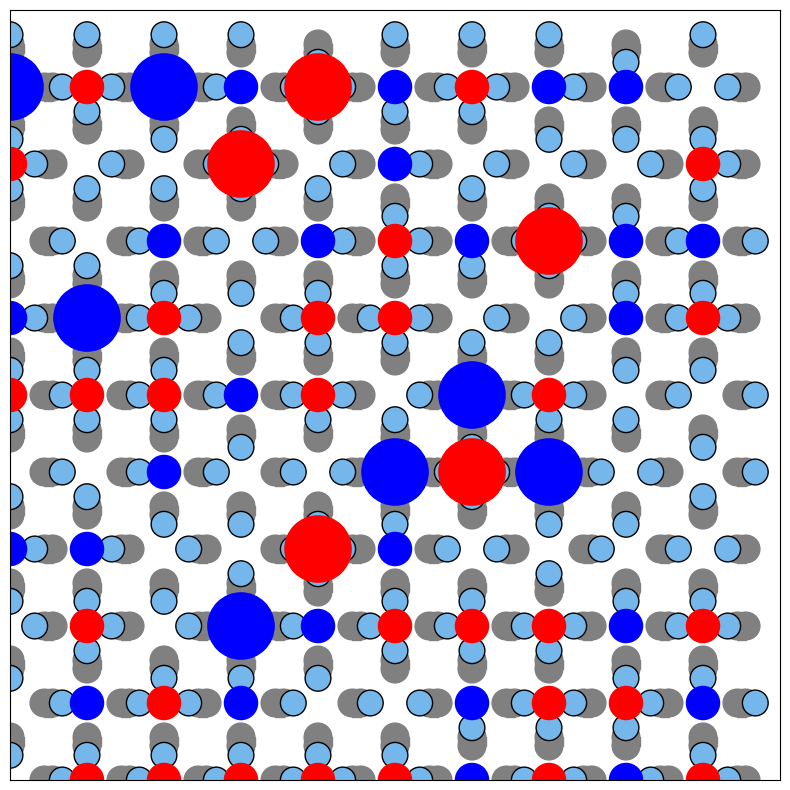

In [52]:
fig, ax= plt.subplots(figsize=(10,10))


region_limit = N*params['lattice_constant'].magnitude
ice.draw_frame(trj, frame_no=0,
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

mc.display_vertices(trj,N,a,ax)
#mc.display_arrows(trj,N,a,ax)
#mc.display_lines(trj,N,a,ax)

plt.show()

In [53]:
trj['realization'] = [1]*len(trj)

In [54]:
file_path = f'../data/q2_degeneracy/random{10}.csv'
trj.to_csv(file_path)